# Twitter Sentiment Analysis Pipeline

This notebook implements a complete sentiment analysis pipeline for Twitter data with:
- Data loading and preprocessing
- Text cleaning (stopwords, punctuation, special characters)
- Sentiment classification using Logistic Regression or Naive Bayes
- Visualization of sentiment distribution

## Required Libraries


In [1]:
!pip install nltk
!pip install sklearn
!pip install numpy
!pip install pandas 

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [2]:
!pip install seaborn

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print("NLTK data downloaded!")


Libraries imported successfully!
NLTK data downloaded!


## 1. Data Loading Module

Function to load tweet dataset from CSV or JSON format.


In [4]:
def load_tweet_dataset(file_path, file_type='csv', text_column='text', label_column='sentiment'):
    """
    Load tweet dataset from CSV or JSON file.
    
    Parameters:
    -----------
    file_path : str
        Path to the dataset file
    file_type : str, optional
        Type of file: 'csv' or 'json' (default: 'csv')
    text_column : str, optional
        Name of the column containing tweet text (default: 'text')
    label_column : str, optional
        Name of the column containing sentiment labels (default: 'sentiment')
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing tweets and labels
    """
    try:
        if file_type.lower() == 'csv':
            df = pd.read_csv(file_path)
        elif file_type.lower() == 'json':
            df = pd.read_json(file_path)
        else:
            raise ValueError("file_type must be 'csv' or 'json'")
        
        # Validate required columns exist
        if text_column not in df.columns:
            raise ValueError(f"Text column '{text_column}' not found in dataset")
        
        # Select only required columns if label column exists
        if label_column in df.columns:
            df = df[[text_column, label_column]].copy()
            df.columns = ['text', 'sentiment']
        else:
            # If no label column, create one with None values
            df = df[[text_column]].copy()
            df.columns = ['text']
            df['sentiment'] = None
        
        # Remove rows with missing text
        df = df[df['text'].notna()].copy()
        df = df[df['text'] != ''].copy()
        
        print(f"Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None

# Create sample dataset if no file is available
def create_sample_dataset():
    """
    Create a sample tweet dataset for demonstration purposes.
    
    Returns:
    --------
    pd.DataFrame
        Sample dataset with tweets and sentiment labels
    """
    sample_tweets = [
        "I love this product! It's amazing and works perfectly! #excited",
        "This is the worst service I've ever experienced. Very disappointed.",
        "The weather today is okay, nothing special really.",
        "Great movie! Had a wonderful time watching it with friends.",
        "Terrible customer support. They didn't help me at all.",
        "It's a regular day, nothing much happened.",
        "Fantastic news! I'm so happy about this development!",
        "I hate waiting in long queues. Very frustrating experience.",
        "The food was decent, neither great nor bad.",
        "Outstanding performance! Best I've seen in years!",
        "Awful experience, would not recommend to anyone.",
        "Normal day at work, nothing special.",
        "I'm thrilled about the new features! This is exactly what I needed!",
        "Disgusting! The quality is terrible.",
        "It's fine, nothing to complain about.",
        "Perfect solution for my problem! Highly satisfied!",
        "Very poor quality, completely unsatisfied.",
        "Average product, meets basic expectations.",
        "Incredible! This exceeded all my expectations!",
        "Horrible! Worst purchase I've ever made.",
    ]
    
    sample_labels = [
        'positive', 'negative', 'neutral',
        'positive', 'negative', 'neutral',
        'positive', 'negative', 'neutral',
        'positive', 'negative', 'neutral',
        'positive', 'negative', 'neutral',
        'positive', 'negative', 'neutral',
        'positive', 'negative',
    ]
    
    df = pd.DataFrame({
        'text': sample_tweets,
        'sentiment': sample_labels
    })
    
    return df

# Load or create sample dataset
print("Loading sample dataset...")
tweets_df = create_sample_dataset()
print("\nFirst few rows:")
print(tweets_df.head())
print("\nSentiment distribution:")
print(tweets_df['sentiment'].value_counts())


Loading sample dataset...

First few rows:
                                                text sentiment
0  I love this product! It's amazing and works pe...  positive
1  This is the worst service I've ever experience...  negative
2  The weather today is okay, nothing special rea...   neutral
3  Great movie! Had a wonderful time watching it ...  positive
4  Terrible customer support. They didn't help me...  negative

Sentiment distribution:
sentiment
positive    7
negative    7
neutral     6
Name: count, dtype: int64


In [9]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

## 2. Text Preprocessing Module

Functions to clean and preprocess tweet text:
- Remove URLs, mentions, hashtags (optionally)
- Convert to lowercase
- Remove punctuation and special characters
- Tokenize text
- Remove stopwords
- Apply stemming (optional)


In [10]:
class TweetPreprocessor:
    """
    Class for preprocessing tweet text data.
    """
    
    def __init__(self, remove_urls=True, remove_mentions=True, 
                 remove_hashtags=False, stem_words=True, language='english'):
        """
        Initialize the preprocessor.
        
        Parameters:
        -----------
        remove_urls : bool, optional
            Whether to remove URLs (default: True)
        remove_mentions : bool, optional
            Whether to remove @mentions (default: True)
        remove_hashtags : bool, optional
            Whether to remove #hashtags (default: False)
        stem_words : bool, optional
            Whether to apply stemming (default: True)
        language : str, optional
            Language for stopwords (default: 'english')
        """
        self.remove_urls = remove_urls
        self.remove_mentions = remove_mentions
        self.remove_hashtags = remove_hashtags
        self.stem_words = stem_words
        
        # Load stopwords
        try:
            self.stop_words = set(stopwords.words(language))
        except:
            print(f"Warning: Could not load stopwords for '{language}'. Using empty set.")
            self.stop_words = set()
        
        # Initialize stemmer
        if self.stem_words:
            self.stemmer = PorterStemmer()
        else:
            self.stemmer = None
    
    def clean_text(self, text):
        """
        Clean a single tweet text.
        
        Parameters:
        -----------
        text : str
            Raw tweet text
        
        Returns:
        --------
        str
            Cleaned text
        """
        if pd.isna(text) or text == '':
            return ''
        
        # Convert to string
        text = str(text)
        
        # Remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove user mentions
        if self.remove_mentions:
            text = re.sub(r'@\w+', '', text)
        
        # Remove hashtags (but keep the word)
        if self.remove_hashtags:
            text = re.sub(r'#', '', text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation and special characters (keep alphanumeric and spaces)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        
        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_remove_stopwords(self, text):
        """
        Tokenize text and remove stopwords.
        
        Parameters:
        -----------
        text : str
            Cleaned text
        
        Returns:
        --------
        list
            List of tokens (words) without stopwords
        """
        if text == '':
            return []
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        tokens = [token for token in tokens if token not in self.stop_words]
        
        # Apply stemming if enabled
        if self.stem_words and self.stemmer:
            tokens = [self.stemmer.stem(token) for token in tokens]
        
        return tokens
    
    def preprocess(self, text):
        """
        Complete preprocessing pipeline for a single tweet.
        
        Parameters:
        -----------
        text : str
            Raw tweet text
        
        Returns:
        --------
        str
            Preprocessed text as a single string
        """
        # Clean text
        cleaned = self.clean_text(text)
        
        # Tokenize and remove stopwords
        tokens = self.tokenize_and_remove_stopwords(cleaned)
        
        # Join tokens back into string
        return ' '.join(tokens)
    
    def preprocess_dataframe(self, df, text_column='text'):
        """
        Preprocess all texts in a DataFrame.
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing tweet texts
        text_column : str, optional
            Name of the column containing text (default: 'text')
        
        Returns:
        --------
        pd.DataFrame
            DataFrame with new 'preprocessed_text' column
        """
        df = df.copy()
        df['preprocessed_text'] = df[text_column].apply(self.preprocess)
        
        # Remove rows with empty preprocessed text
        df = df[df['preprocessed_text'] != ''].copy()
        
        return df

# Initialize preprocessor
preprocessor = TweetPreprocessor(
    remove_urls=True,
    remove_mentions=True,
    remove_hashtags=False,  # Keep hashtags for sentiment analysis
    stem_words=True,
    language='english'
)

# Preprocess the dataset
print("Preprocessing tweets...")
tweets_df = preprocessor.preprocess_dataframe(tweets_df, text_column='text')

print("\nPreprocessing complete!")
print("\nSample of original vs preprocessed text:")
print(tweets_df[['text', 'preprocessed_text']].head(10))


Preprocessing tweets...

Preprocessing complete!

Sample of original vs preprocessed text:
                                                text  \
0  I love this product! It's amazing and works pe...   
1  This is the worst service I've ever experience...   
2  The weather today is okay, nothing special rea...   
3  Great movie! Had a wonderful time watching it ...   
4  Terrible customer support. They didn't help me...   
5         It's a regular day, nothing much happened.   
6  Fantastic news! I'm so happy about this develo...   
7  I hate waiting in long queues. Very frustratin...   
8        The food was decent, neither great nor bad.   
9  Outstanding performance! Best I've seen in years!   

                            preprocessed_text  
0      love product amaz work perfectli excit  
1  worst servic ive ever experienc disappoint  
2      weather today okay noth special realli  
3         great movi wonder time watch friend  
4           terribl custom support didnt help  
5   

## 3. Sentiment Classification Model

Train a sentiment classifier using either Logistic Regression or Naive Bayes.


In [11]:
class SentimentClassifier:
    """
    Class for sentiment classification using Logistic Regression or Naive Bayes.
    """
    
    def __init__(self, model_type='logistic_regression', max_features=5000):
        """
        Initialize the sentiment classifier.
        
        Parameters:
        -----------
        model_type : str, optional
            Type of model: 'logistic_regression' or 'naive_bayes' (default: 'logistic_regression')
        max_features : int, optional
            Maximum number of features for TF-IDF vectorizer (default: 5000)
        """
        self.model_type = model_type.lower()
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
        self.model = None
        self.label_encoder = None
        
        # Initialize model based on type
        if self.model_type == 'logistic_regression':
            self.model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
        elif self.model_type == 'naive_bayes':
            self.model = MultinomialNB(alpha=1.0)
        else:
            raise ValueError("model_type must be 'logistic_regression' or 'naive_bayes'")
    
    def prepare_features(self, texts):
        """
        Convert texts to TF-IDF features.
        
        Parameters:
        -----------
        texts : array-like
            List or Series of preprocessed texts
        
        Returns:
        --------
        scipy.sparse.csr_matrix
            TF-IDF feature matrix
        """
        return self.vectorizer.fit_transform(texts) if not hasattr(self, '_vectorizer_fitted') else self.vectorizer.transform(texts)
    
    def train(self, X, y, test_size=0.2, random_state=42):
        """
        Train the sentiment classifier.
        
        Parameters:
        -----------
        X : array-like
            Preprocessed texts
        y : array-like
            Sentiment labels (positive, neutral, negative)
        test_size : float, optional
            Proportion of data to use for testing (default: 0.2)
        random_state : int, optional
            Random seed for reproducibility (default: 42)
        
        Returns:
        --------
        dict
            Dictionary containing training results and metrics
        """
        # Convert labels to numeric if needed
        from sklearn.preprocessing import LabelEncoder
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        self.label_encoder = label_encoder
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
        )
        
        # Vectorize texts
        print("Vectorizing texts...")
        X_train_vec = self.vectorizer.fit_transform(X_train)
        X_test_vec = self.vectorizer.transform(X_test)
        self._vectorizer_fitted = True
        
        # Train model
        print(f"Training {self.model_type} model...")
        self.model.fit(X_train_vec, y_train)
        
        # Predictions
        y_train_pred = self.model.predict(X_train_vec)
        y_test_pred = self.model.predict(X_test_vec)
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # Classification report
        class_names = label_encoder.classes_
        test_report = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
        
        results = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'classification_report': test_report,
            'confusion_matrix': confusion_matrix(y_test, y_test_pred),
            'class_names': class_names
        }
        
        print(f"\nTraining Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_test_pred, target_names=class_names))
        
        return results
    
    def predict(self, texts):
        """
        Predict sentiment for given texts.
        
        Parameters:
        -----------
        texts : array-like
            List or Series of preprocessed texts
        
        Returns:
        --------
        numpy.ndarray
            Predicted sentiment labels
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet. Call train() first.")
        
        # Vectorize texts
        texts_vec = self.vectorizer.transform(texts)
        
        # Predict
        predictions_encoded = self.model.predict(texts_vec)
        
        # Convert back to original labels
        if self.label_encoder is not None:
            predictions = self.label_encoder.inverse_transform(predictions_encoded)
        else:
            predictions = predictions_encoded
        
        return predictions
    
    def predict_proba(self, texts):
        """
        Predict sentiment probabilities for given texts.
        
        Parameters:
        -----------
        texts : array-like
            List or Series of preprocessed texts
        
        Returns:
        --------
        numpy.ndarray
            Probability matrix for each class
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet. Call train() first.")
        
        # Vectorize texts
        texts_vec = self.vectorizer.transform(texts)
        
        # Predict probabilities
        probabilities = self.model.predict_proba(texts_vec)
        
        return probabilities

# Prepare data for training
print("Preparing data for training...")
X = tweets_df['preprocessed_text'].values
y = tweets_df['sentiment'].values

print(f"Total samples: {len(X)}")
print(f"Sentiment distribution: {pd.Series(y).value_counts().to_dict()}")

# Train Logistic Regression model
print("\n" + "="*60)
print("Training Logistic Regression Model")
print("="*60)
lr_classifier = SentimentClassifier(model_type='logistic_regression', max_features=5000)
lr_results = lr_classifier.train(X, y, test_size=0.2, random_state=42)

# Also train Naive Bayes for comparison
print("\n" + "="*60)
print("Training Naive Bayes Model")
print("="*60)
nb_classifier = SentimentClassifier(model_type='naive_bayes', max_features=5000)
nb_results = nb_classifier.train(X, y, test_size=0.2, random_state=42)

# Compare models
print("\n" + "="*60)
print("Model Comparison")
print("="*60)
print(f"Logistic Regression Test Accuracy: {lr_results['test_accuracy']:.4f}")
print(f"Naive Bayes Test Accuracy: {nb_results['test_accuracy']:.4f}")

# Select best model
if lr_results['test_accuracy'] >= nb_results['test_accuracy']:
    classifier = lr_classifier
    model_name = "Logistic Regression"
else:
    classifier = nb_classifier
    model_name = "Naive Bayes"

print(f"\nSelected model: {model_name}")


Preparing data for training...
Total samples: 20
Sentiment distribution: {'positive': 7, 'negative': 7, 'neutral': 6}

Training Logistic Regression Model
Vectorizing texts...
Training logistic_regression model...

Training Accuracy: 1.0000
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         2
     neutral       1.00      1.00      1.00         1
    positive       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


Training Naive Bayes Model
Vectorizing texts...
Training naive_bayes model...

Training Accuracy: 1.0000
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         2
     neutral       1.00      1.00      1.00         1
    positive      

E:\ANACONDA\ANACONDA\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## 4. Sentiment Prediction

Predict sentiment labels for sample tweets.


In [12]:
# Predict sentiment for all tweets in the dataset
print("Predicting sentiments for all tweets...")
predictions = classifier.predict(tweets_df['preprocessed_text'].values)
probabilities = classifier.predict_proba(tweets_df['preprocessed_text'].values)

# Add predictions to dataframe
tweets_df['predicted_sentiment'] = predictions
tweets_df['positive_prob'] = probabilities[:, list(classifier.label_encoder.classes_).index('positive')]
tweets_df['neutral_prob'] = probabilities[:, list(classifier.label_encoder.classes_).index('neutral')]
tweets_df['negative_prob'] = probabilities[:, list(classifier.label_encoder.classes_).index('negative')]

print("\nSample predictions:")
sample_results = tweets_df[['text', 'sentiment', 'predicted_sentiment', 
                            'positive_prob', 'neutral_prob', 'negative_prob']].head(10)
print(sample_results.to_string())

# Display some example predictions
print("\n" + "="*80)
print("Example Predictions:")
print("="*80)
for idx, row in tweets_df.head(5).iterrows():
    print(f"\nTweet: {row['text']}")
    print(f"Actual: {row['sentiment']} | Predicted: {row['predicted_sentiment']}")
    print(f"Probabilities - Positive: {row['positive_prob']:.3f}, "
          f"Neutral: {row['neutral_prob']:.3f}, "
          f"Negative: {row['negative_prob']:.3f}")


Predicting sentiments for all tweets...

Sample predictions:
                                                                  text sentiment predicted_sentiment  positive_prob  neutral_prob  negative_prob
0      I love this product! It's amazing and works perfectly! #excited  positive            positive       0.538747      0.239563       0.221689
1  This is the worst service I've ever experienced. Very disappointed.  negative            negative       0.262366      0.212045       0.525589
2                   The weather today is okay, nothing special really.   neutral             neutral       0.254700      0.528672       0.216629
3          Great movie! Had a wonderful time watching it with friends.  positive            positive       0.545223      0.230744       0.224033
4               Terrible customer support. They didn't help me at all.  negative            negative       0.277980      0.229971       0.492049
5                           It's a regular day, nothing much happened

## 5. Sentiment Distribution Visualization

Create visualizations to analyze sentiment distribution.


Creating visualizations for actual sentiment distribution...


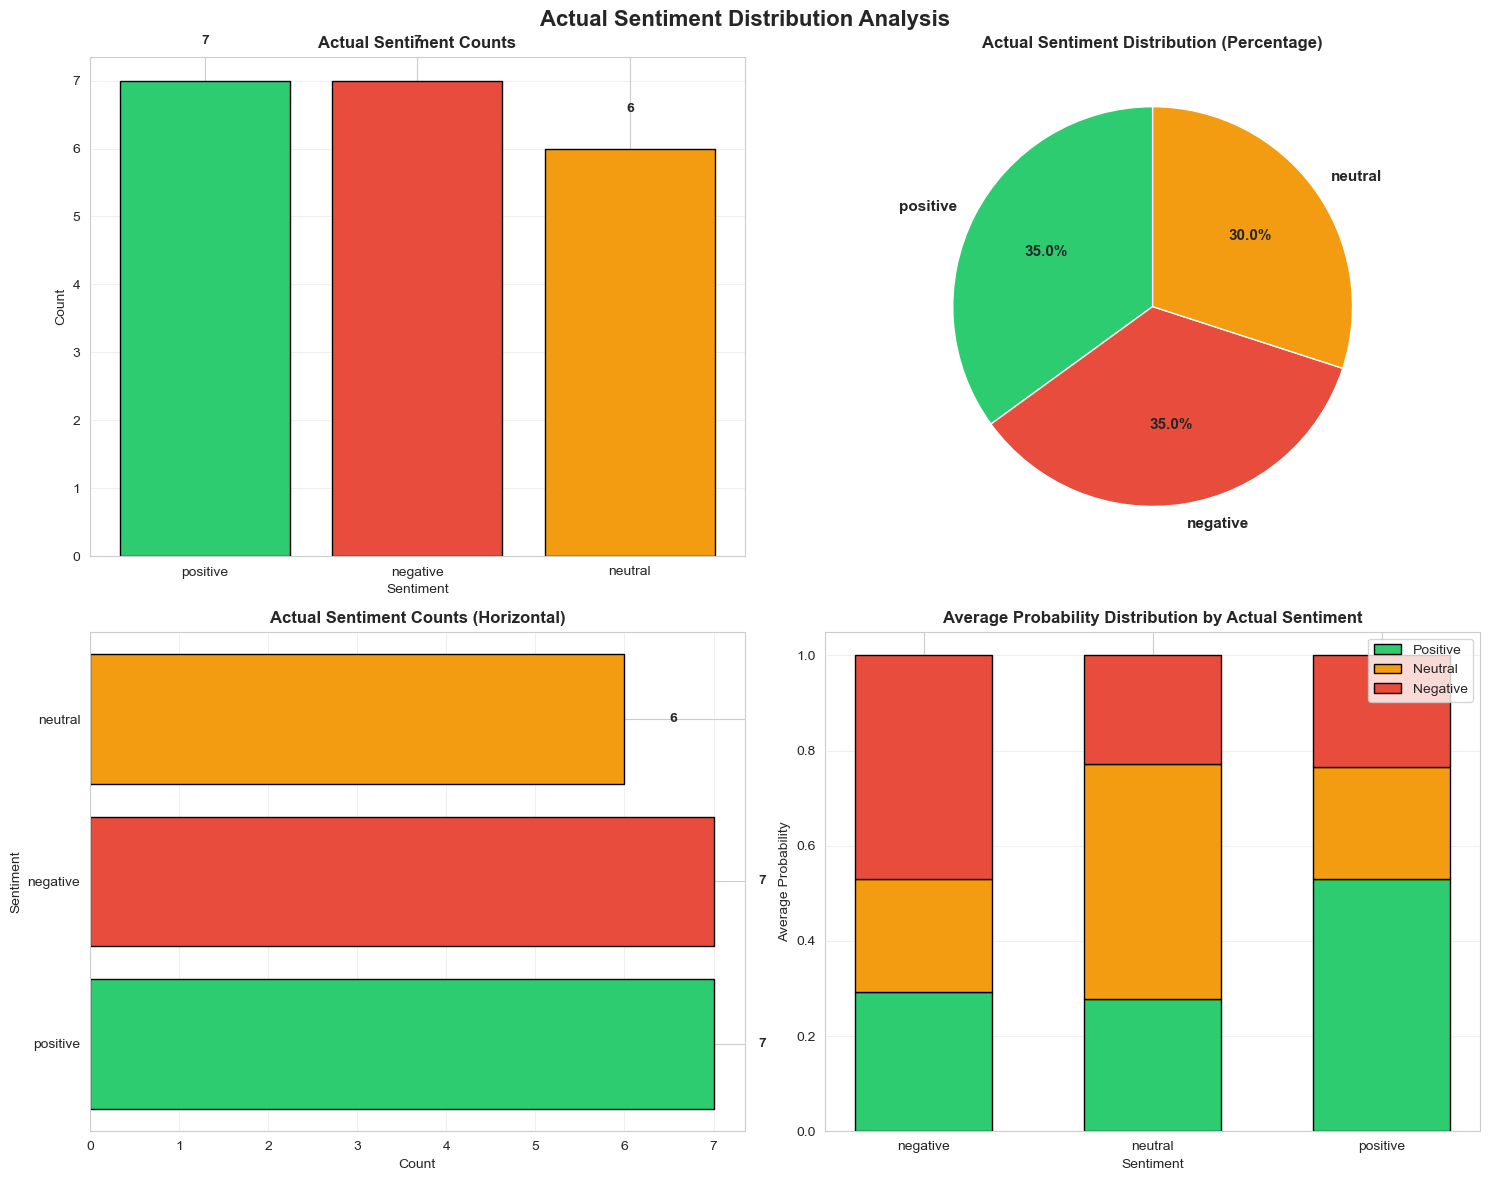


Actual Sentiment Summary:
--------------------------------------------------
Positive  :   7 (35.00%)
Negative  :   7 (35.00%)
Neutral   :   6 (30.00%)
--------------------------------------------------
Total       :  20 (100.00%)

Creating visualizations for predicted sentiment distribution...


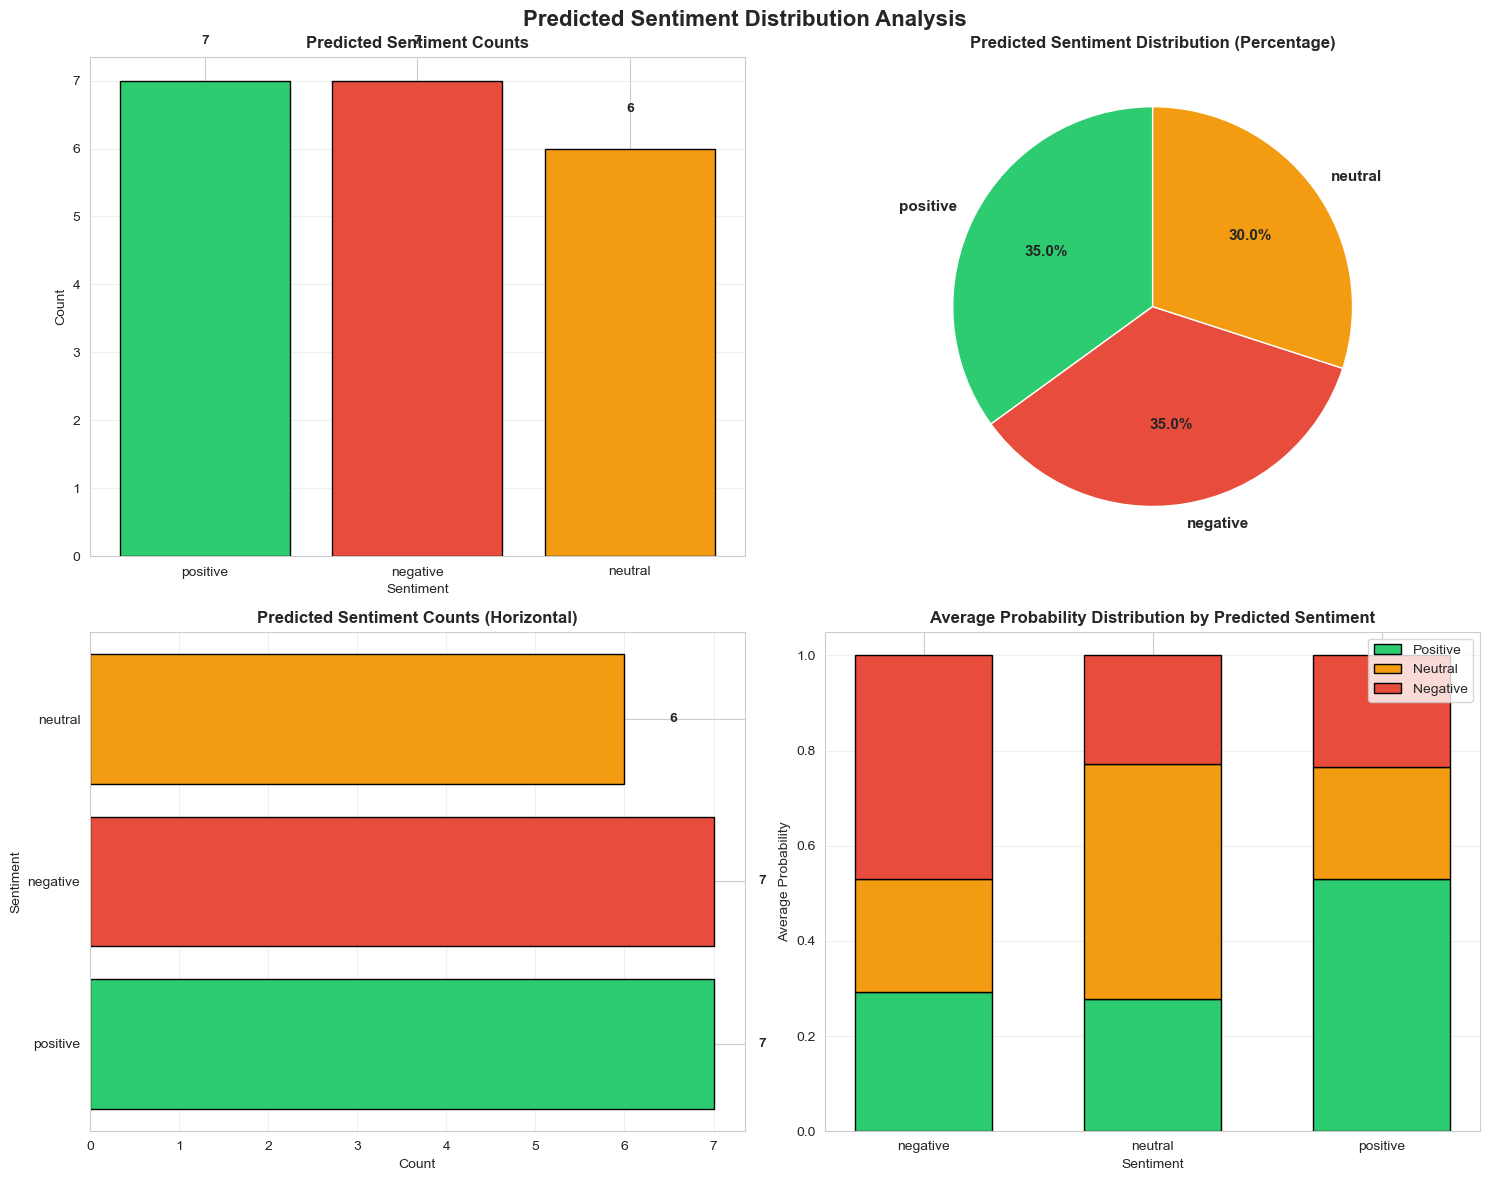


Predicted Sentiment Summary:
--------------------------------------------------
Positive  :   7 (35.00%)
Negative  :   7 (35.00%)
Neutral   :   6 (30.00%)
--------------------------------------------------
Total       :  20 (100.00%)


In [13]:
def visualize_sentiment_distribution(df, sentiment_col='sentiment', title_prefix='Actual'):
    """
    Create comprehensive visualizations of sentiment distribution.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with sentiment labels
    sentiment_col : str, optional
        Name of sentiment column (default: 'sentiment')
    title_prefix : str, optional
        Prefix for plot titles (default: 'Actual')
    """
    # Set up the figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title_prefix} Sentiment Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Bar plot of sentiment counts
    sentiment_counts = df[sentiment_col].value_counts()
    colors = {'positive': '#2ecc71', 'neutral': '#f39c12', 'negative': '#e74c3c'}
    sentiment_colors = [colors.get(sent, '#95a5a6') for sent in sentiment_counts.index]
    
    axes[0, 0].bar(sentiment_counts.index, sentiment_counts.values, color=sentiment_colors, edgecolor='black')
    axes[0, 0].set_title(f'{title_prefix} Sentiment Counts', fontweight='bold')
    axes[0, 0].set_xlabel('Sentiment')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (sent, count) in enumerate(sentiment_counts.items()):
        axes[0, 0].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')
    
    # 2. Pie chart of sentiment distribution
    axes[0, 1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
                   colors=sentiment_colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    axes[0, 1].set_title(f'{title_prefix} Sentiment Distribution (Percentage)', fontweight='bold')
    
    # 3. Horizontal bar plot
    axes[1, 0].barh(sentiment_counts.index, sentiment_counts.values, color=sentiment_colors, edgecolor='black')
    axes[1, 0].set_title(f'{title_prefix} Sentiment Counts (Horizontal)', fontweight='bold')
    axes[1, 0].set_xlabel('Count')
    axes[1, 0].set_ylabel('Sentiment')
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (sent, count) in enumerate(sentiment_counts.items()):
        axes[1, 0].text(count + 0.5, i, str(count), va='center', fontweight='bold')
    
    # 4. Stacked bar plot (if probabilities are available)
    if all(col in df.columns for col in ['positive_prob', 'neutral_prob', 'negative_prob']):
        # Group by sentiment and calculate average probabilities
        prob_cols = ['positive_prob', 'neutral_prob', 'negative_prob']
        avg_probs = df.groupby(sentiment_col)[prob_cols].mean()
        
        x = np.arange(len(avg_probs.index))
        width = 0.6
        
        axes[1, 1].bar(x, avg_probs['positive_prob'], width, label='Positive', color='#2ecc71', edgecolor='black')
        axes[1, 1].bar(x, avg_probs['neutral_prob'], width, bottom=avg_probs['positive_prob'],
                       label='Neutral', color='#f39c12', edgecolor='black')
        axes[1, 1].bar(x, avg_probs['negative_prob'], width,
                       bottom=avg_probs['positive_prob'] + avg_probs['neutral_prob'],
                       label='Negative', color='#e74c3c', edgecolor='black')
        
        axes[1, 1].set_title(f'Average Probability Distribution by {title_prefix} Sentiment', fontweight='bold')
        axes[1, 1].set_xlabel('Sentiment')
        axes[1, 1].set_ylabel('Average Probability')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(avg_probs.index)
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
    else:
        # If no probabilities, show a simple count plot
        sns.countplot(data=df, y=sentiment_col, ax=axes[1, 1], palette=colors)
        axes[1, 1].set_title(f'{title_prefix} Sentiment Distribution (Count Plot)', fontweight='bold')
        axes[1, 1].set_xlabel('Count')
        axes[1, 1].set_ylabel('Sentiment')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{title_prefix} Sentiment Summary:")
    print("-" * 50)
    total = len(df)
    for sentiment in sentiment_counts.index:
        count = sentiment_counts[sentiment]
        percentage = (count / total) * 100
        print(f"{sentiment.capitalize():10s}: {count:3d} ({percentage:5.2f}%)")
    print("-" * 50)
    print(f"Total       : {total:3d} (100.00%)")

# Visualize actual sentiment distribution
print("Creating visualizations for actual sentiment distribution...")
visualize_sentiment_distribution(tweets_df, sentiment_col='sentiment', title_prefix='Actual')

# Visualize predicted sentiment distribution
print("\n" + "="*80)
print("Creating visualizations for predicted sentiment distribution...")
visualize_sentiment_distribution(tweets_df, sentiment_col='predicted_sentiment', title_prefix='Predicted')


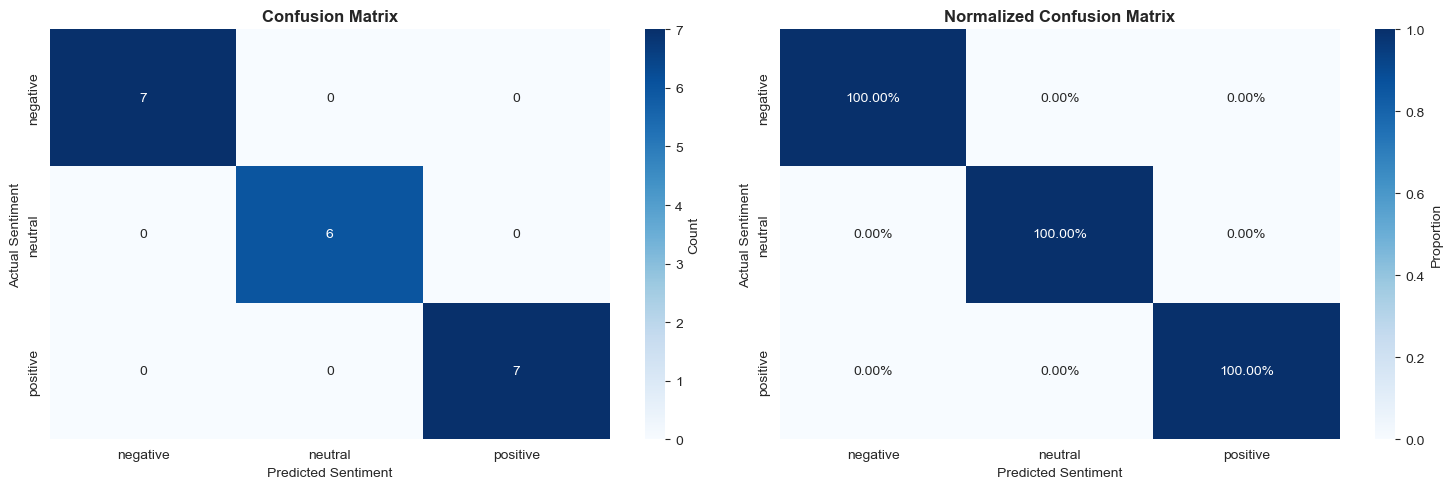


Overall Prediction Accuracy: 1.0000 (100.00%)


In [14]:
# Additional visualization: Confusion Matrix
if 'sentiment' in tweets_df.columns and 'predicted_sentiment' in tweets_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confusion Matrix
    cm = confusion_matrix(tweets_df['sentiment'], tweets_df['predicted_sentiment'],
                          labels=classifier.label_encoder.classes_)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classifier.label_encoder.classes_,
                yticklabels=classifier.label_encoder.classes_,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Predicted Sentiment')
    axes[0].set_ylabel('Actual Sentiment')
    
    # Normalized Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=classifier.label_encoder.classes_,
                yticklabels=classifier.label_encoder.classes_,
                ax=axes[1], cbar_kws={'label': 'Proportion'})
    axes[1].set_title('Normalized Confusion Matrix', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Predicted Sentiment')
    axes[1].set_ylabel('Actual Sentiment')
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy
    accuracy = accuracy_score(tweets_df['sentiment'], tweets_df['predicted_sentiment'])
    print(f"\nOverall Prediction Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


## 6. Complete Pipeline Function

A single function to run the entire sentiment analysis pipeline.


Running complete sentiment analysis pipeline...


TWITTER SENTIMENT ANALYSIS PIPELINE

[Step 1] Loading data...

[Step 2] Preprocessing tweets...

[Step 3] Training sentiment classifier...
Vectorizing texts...
Training logistic_regression model...

Training Accuracy: 1.0000
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         2
     neutral       1.00      1.00      1.00         1
    positive       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


[Step 4] Making predictions...

[Step 5] Creating visualizations...


E:\ANACONDA\ANACONDA\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


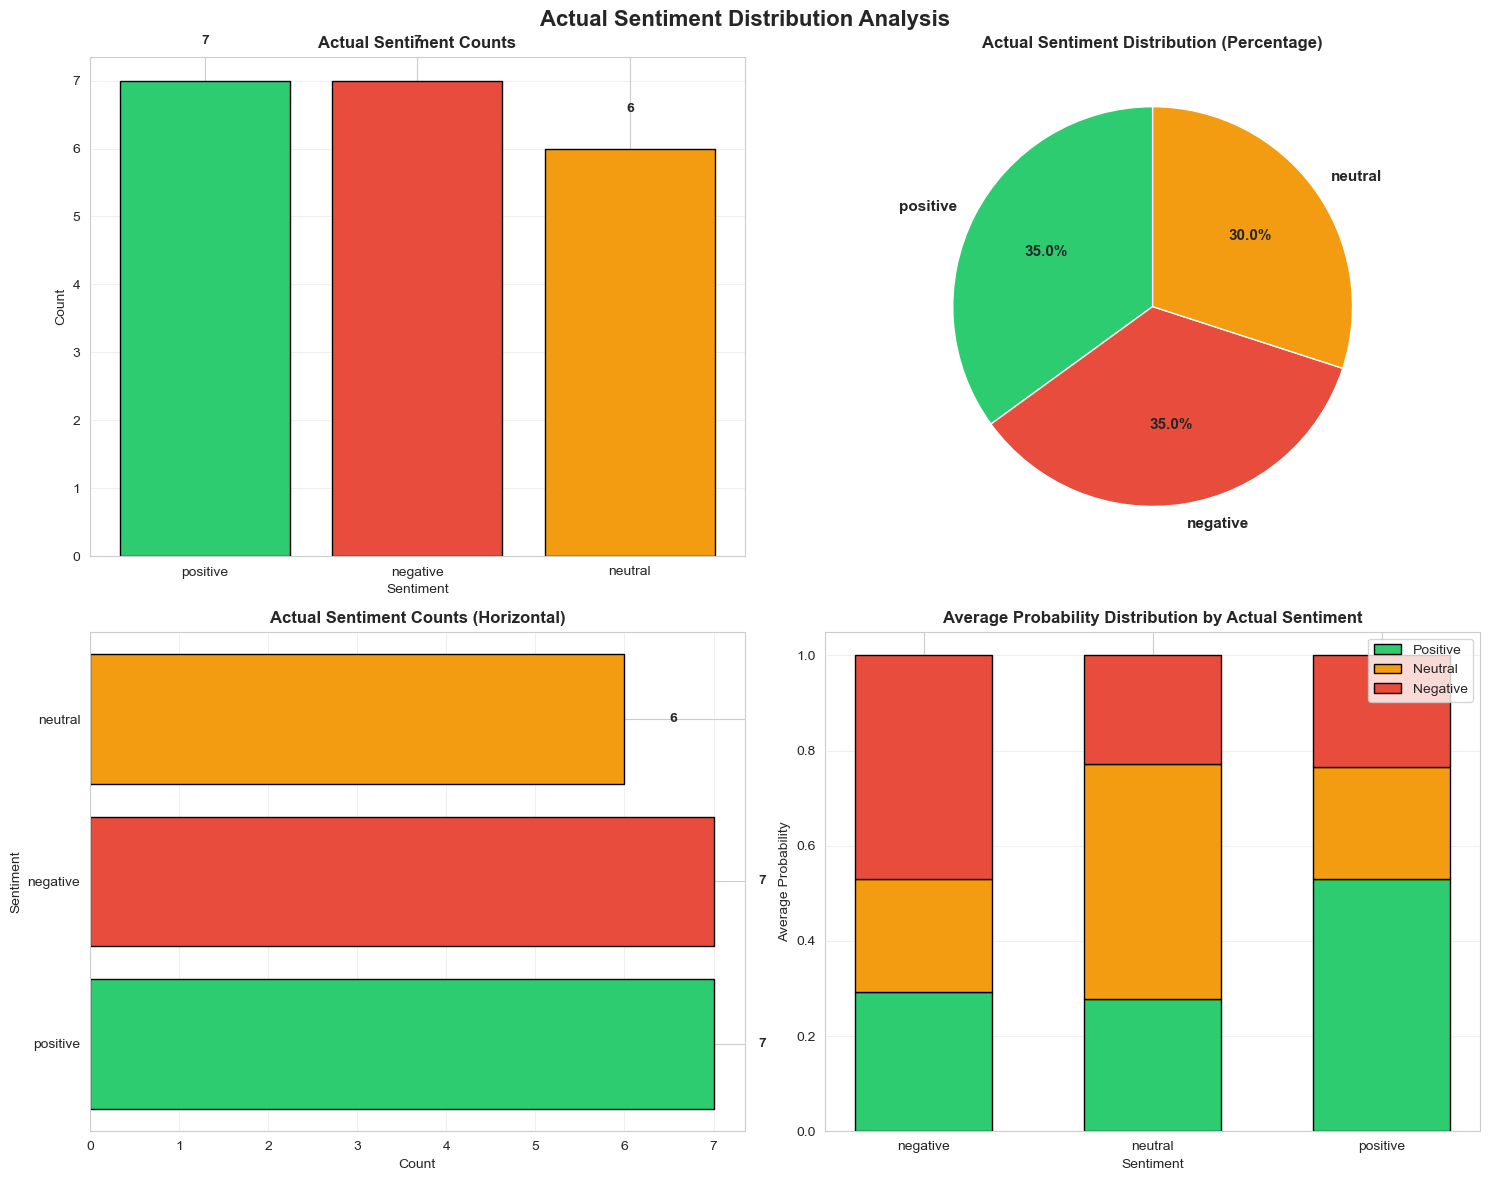


Actual Sentiment Summary:
--------------------------------------------------
Positive  :   7 (35.00%)
Negative  :   7 (35.00%)
Neutral   :   6 (30.00%)
--------------------------------------------------
Total       :  20 (100.00%)


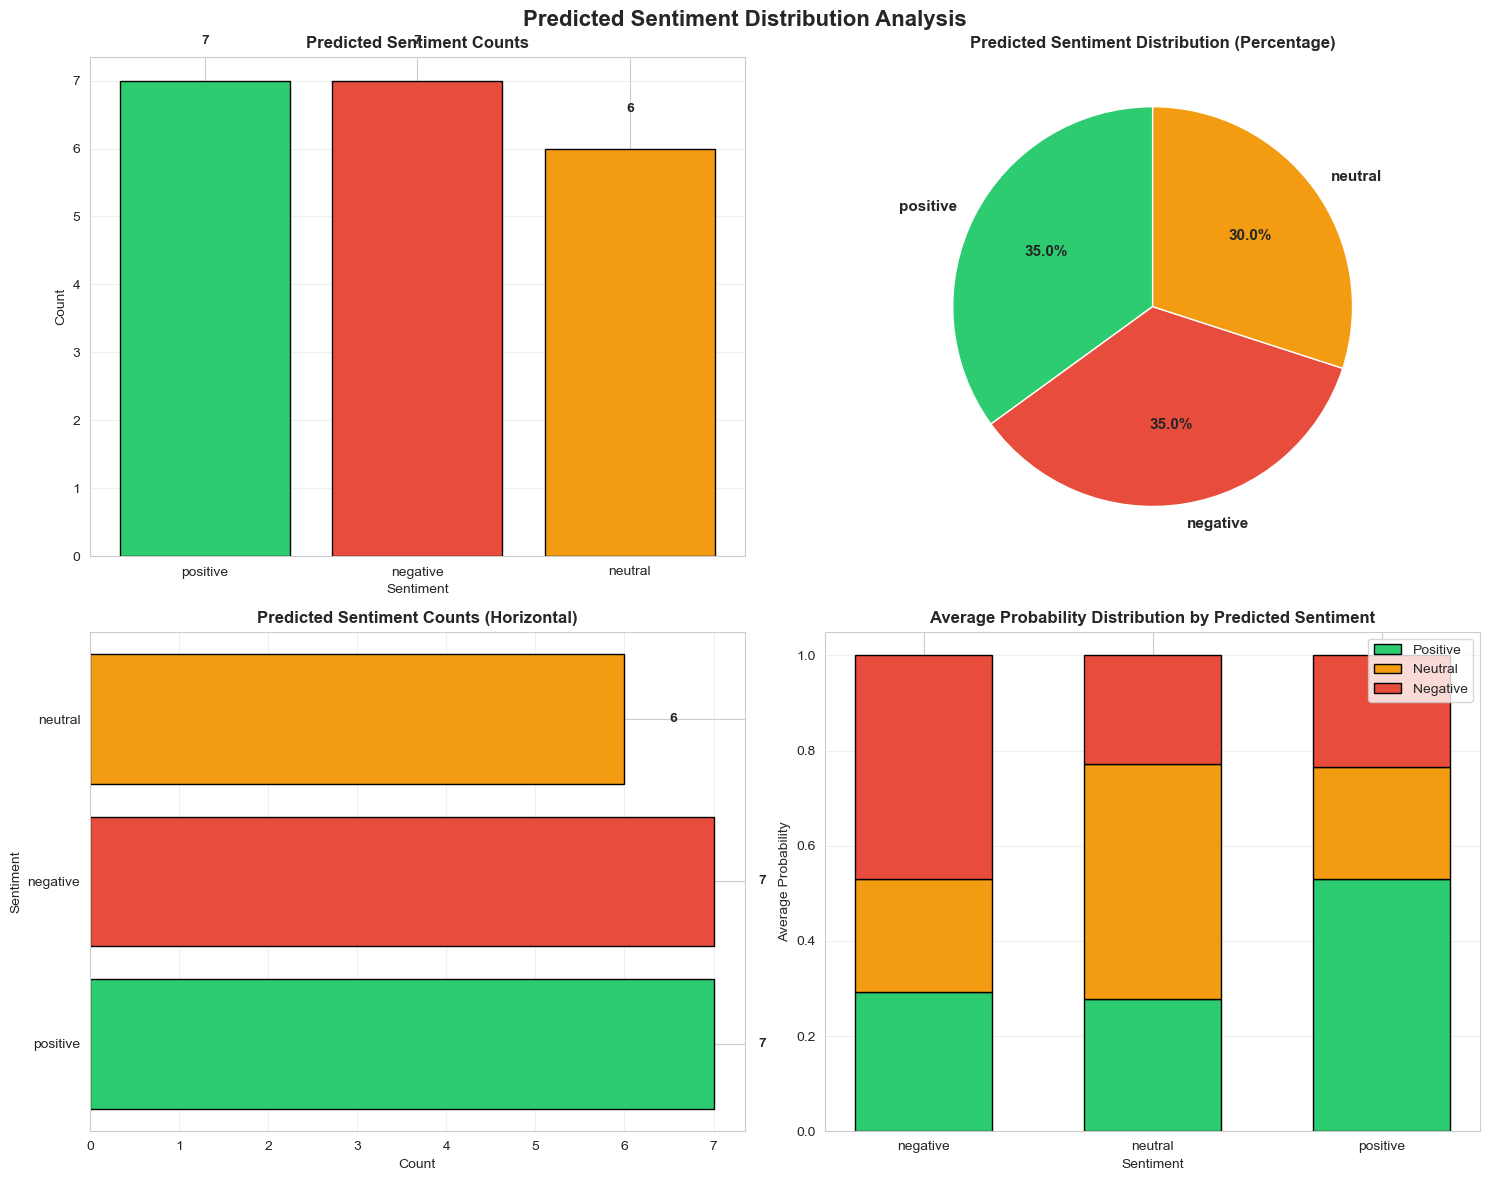


Predicted Sentiment Summary:
--------------------------------------------------
Positive  :   7 (35.00%)
Negative  :   7 (35.00%)
Neutral   :   6 (30.00%)
--------------------------------------------------
Total       :  20 (100.00%)

PIPELINE COMPLETE!

Final DataFrame Shape: (20, 7)

Final DataFrame Columns: ['text', 'sentiment', 'preprocessed_text', 'predicted_sentiment', 'positive_prob', 'neutral_prob', 'negative_prob']


In [15]:
def sentiment_analysis_pipeline(data_source=None, file_path=None, file_type='csv',
                                model_type='logistic_regression', visualize=True):
    """
    Complete sentiment analysis pipeline.
    
    Parameters:
    -----------
    data_source : pd.DataFrame, optional
        DataFrame with tweet data (if None, will use file_path or create sample)
    file_path : str, optional
        Path to dataset file (CSV or JSON)
    file_type : str, optional
        Type of file: 'csv' or 'json' (default: 'csv')
    model_type : str, optional
        Model type: 'logistic_regression' or 'naive_bayes' (default: 'logistic_regression')
    visualize : bool, optional
        Whether to create visualizations (default: True)
    
    Returns:
    --------
    tuple
        (dataframe, classifier, results)
    """
    print("="*80)
    print("TWITTER SENTIMENT ANALYSIS PIPELINE")
    print("="*80)
    
    # Step 1: Load data
    print("\n[Step 1] Loading data...")
    if data_source is not None:
        df = data_source.copy()
    elif file_path is not None:
        df = load_tweet_dataset(file_path, file_type=file_type)
        if df is None:
            print("Error loading data. Creating sample dataset...")
            df = create_sample_dataset()
    else:
        df = create_sample_dataset()
    
    # Step 2: Preprocess
    print("\n[Step 2] Preprocessing tweets...")
    preprocessor = TweetPreprocessor(
        remove_urls=True,
        remove_mentions=True,
        remove_hashtags=False,
        stem_words=True,
        language='english'
    )
    df = preprocessor.preprocess_dataframe(df, text_column='text')
    
    # Step 3: Train model (only if labels are available)
    classifier = None
    results = None
    
    if 'sentiment' in df.columns and df['sentiment'].notna().any():
        print("\n[Step 3] Training sentiment classifier...")
        X = df['preprocessed_text'].values
        y = df['sentiment'].values
        
        classifier = SentimentClassifier(model_type=model_type, max_features=5000)
        results = classifier.train(X, y, test_size=0.2, random_state=42)
        
        # Step 4: Predict
        print("\n[Step 4] Making predictions...")
        predictions = classifier.predict(X)
        probabilities = classifier.predict_proba(X)
        
        df['predicted_sentiment'] = predictions
        df['positive_prob'] = probabilities[:, list(classifier.label_encoder.classes_).index('positive')]
        df['neutral_prob'] = probabilities[:, list(classifier.label_encoder.classes_).index('neutral')]
        df['negative_prob'] = probabilities[:, list(classifier.label_encoder.classes_).index('negative')]
    else:
        print("\n[Step 3] No labels available. Skipping training.")
        print("Note: Use classifier.predict() after training on labeled data.")
    
    # Step 5: Visualize
    if visualize and 'sentiment' in df.columns:
        print("\n[Step 5] Creating visualizations...")
        visualize_sentiment_distribution(df, sentiment_col='sentiment', title_prefix='Actual')
        
        if 'predicted_sentiment' in df.columns:
            visualize_sentiment_distribution(df, sentiment_col='predicted_sentiment', title_prefix='Predicted')
    
    print("\n" + "="*80)
    print("PIPELINE COMPLETE!")
    print("="*80)
    
    return df, classifier, results

# Example usage of the complete pipeline
print("Running complete sentiment analysis pipeline...")
print("\n")
final_df, trained_classifier, training_results = sentiment_analysis_pipeline(
    model_type='logistic_regression',
    visualize=True
)

print(f"\nFinal DataFrame Shape: {final_df.shape}")
print(f"\nFinal DataFrame Columns: {final_df.columns.tolist()}")


## 7. Using the Pipeline with Your Own Data

To use this pipeline with your own dataset:

```python
# Option 1: Load from CSV file
df, classifier, results = sentiment_analysis_pipeline(
    file_path='path/to/your/tweets.csv',
    file_type='csv',
    model_type='logistic_regression',  # or 'naive_bayes'
    visualize=True
)

# Option 2: Load from JSON file
df, classifier, results = sentiment_analysis_pipeline(
    file_path='path/to/your/tweets.json',
    file_type='json',
    model_type='naive_bayes',
    visualize=True
)

# Option 3: Use existing DataFrame
your_df = pd.read_csv('your_data.csv')
df, classifier, results = sentiment_analysis_pipeline(
    data_source=your_df,
    model_type='logistic_regression',
    visualize=True
)

# Option 4: Predict sentiment for new tweets
new_tweets = [
    "I love this new feature!",
    "This is terrible.",
    "It's okay, nothing special."
]
preprocessed = [preprocessor.preprocess(tweet) for tweet in new_tweets]
predictions = classifier.predict(preprocessed)
print(predictions)
```
